## Distributed Watershed

Implementation of a distributed watershed function using Dask. Implementation inspired by Juan Nunez-Iglesias [here](https://github.com/dask/dask-image/pull/99). The overall method relies on a two-pass watershed model. The first pass watershed is used to generate and share information about markers across chunk boundaries. The second pass then propagates that information.

This implementation differs from v2. Whereas v2 shares marker information via a specially-labeled chunk boundary basin, this shares information about the first-pass watershed directly.

### Base Imports

In [1]:
import dask
import dask.array as da
import numpy as np
import skimage

### Helper Functions

In [2]:
def compute_mem_mb(shape):
    '''Determines memory consumption of an array with shape in MB'''
    from functools import reduce
    from operator import mul
    count = reduce(mul, shape, 1)
    return count * 8 / ( 1024 ** 2 )

def display(image):
    '''Shows an image in the Jupyter notebook.'''
    from skimage import io
    io.imshow(image)
    io.show()

def frac_to_zscore(frac):
    from scipy.stats import norm
    return norm.ppf(frac)

def grab_overlap(chunk, depth):
    overlap = np.zeros_like(chunk)
    for i in range(0, chunk.ndim):
        idx = [slice(None)]*chunk.ndim
        r = np.array(range(0, chunk.shape[i]))
        idx[i] = (r[:depth], r[-depth:])
        overlap[tuple(idx)] = chunk[tuple(idx)].copy()
    return overlap

def build_full_markers(labels, ws, depth):
    markers = grab_overlap(ws, depth)
    markers[labels > 0] = labels[labels > 0]
    return markers

def create_random_salt_image(fraction_salt, size):
    zscore = frac_to_zscore(1 - fraction_salt)
    salt = np.random.normal(0.0, 1.0, size) > zscore
    return salt    

### Image Geometry Definitions

In [3]:
ndim = 2
size_len = 200
size = ndim * [size_len]
mem_mb = compute_mem_mb(size)
print("2D array size (MB): {:.2f}".format(mem_mb))

2D array size (MB): 0.31


In [4]:
chunk_len = 100
chunks = ndim * [chunk_len]
chunk_mem_mb = compute_mem_mb(chunks)
print("Chunk size (MB): {:.2f}".format(chunk_mem_mb))

Chunk size (MB): 0.08


### Random Seed

In [5]:
seed = 1
np.random.seed(seed=seed)

### Create Random "Salting" Image

C:\Users\wwarr\AppData\Local\Continuum\anaconda3\envs\dask_test\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:75: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


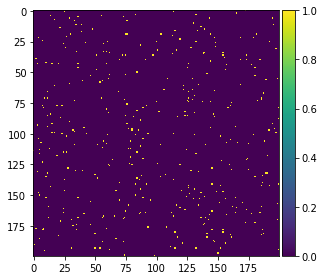

In [6]:
fraction_salt = 1e-2
salt = create_random_salt_image(fraction_salt, size)
#salt = np.flip(salt, axis=0)
display(salt)

### Determine EDT

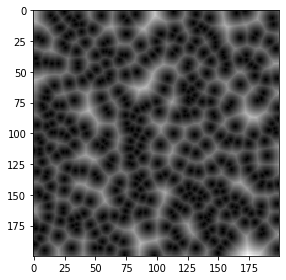

In [7]:
from scipy.ndimage.morphology import distance_transform_edt
edt = distance_transform_edt(~salt)
max_edt = edt.max()
edt = edt / max_edt
display(edt)

### Filter EDT Using H-Max/H-Dome

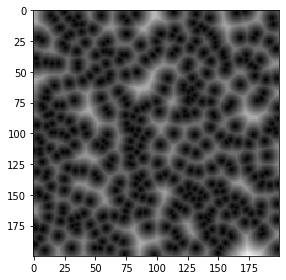

In [8]:
from skimage.morphology import reconstruction
h = 1 / max_edt
h_seed = edt - h
hmax = reconstruction(h_seed, edt, method='dilation')
display(hmax)

### Prepare Marker Image

In [9]:
from skimage.measure import label
ws_markers = label(salt)

### Watershed Transform

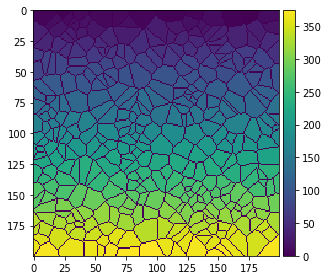

In [10]:
from skimage.morphology import watershed
ws = watershed(hmax, markers=ws_markers, watershed_line=True)
display(ws)

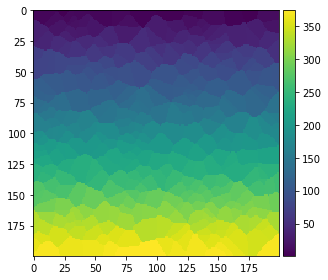

In [11]:
ws = skimage.morphology.dilation(ws, selem=np.ones((3,3)))
display(ws)

### Prepare Dask Client

In [12]:
from dask.distributed import Client
c = Client()
port = c.scheduler_info()['services']['dashboard']
print("Type `http://localhost:{port}` into the URL bar of your favorite browser to watch the following code in action on your machine in real time.".format(port=port))

Type `http://localhost:8787` into the URL bar of your favorite browser to watch the following code in action on your machine in real time.


### Create Dask Arrays

Here we assume future users have access to distributed versions of h-max, EDT, and connected component labeling.

C:\Users\wwarr\AppData\Local\Continuum\anaconda3\envs\dask_test\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:75: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "
C:\Users\wwarr\AppData\Local\Continuum\anaconda3\envs\dask_test\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:78: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  warn("Float image out of standard range; displaying "


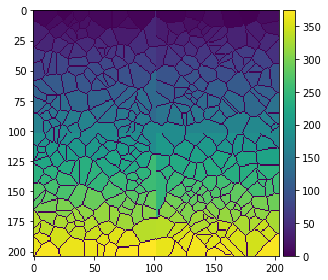

In [13]:
depth = 1

hmax_da = da.from_array(hmax, chunks=chunks)
hmax_op = da.overlap.overlap(hmax_da, depth=depth, boundary='nearest')

ws_markers_da = da.from_array(ws_markers, chunks=chunks)
ws_markers_op = da.overlap.overlap(ws_markers_da, depth=depth, boundary='nearest')

# fp = first pass
ws_fp = hmax_op.map_blocks(lambda x, y: watershed(x, markers=y, watershed_line=True), ws_markers_op, dtype=hmax_op.dtype)
display(ws_fp)

### Create Chunk-wise Marker Images

The per-chunk marker images include both the original markers (from the salt image), and the results of the first-pass watershed shared via overlap.

C:\Users\wwarr\AppData\Local\Continuum\anaconda3\envs\dask_test\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:75: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "
C:\Users\wwarr\AppData\Local\Continuum\anaconda3\envs\dask_test\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:75: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "
C:\Users\wwarr\AppData\Local\Continuum\anaconda3\envs\dask_test\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:78: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  warn("Float image out of standard range; displaying "


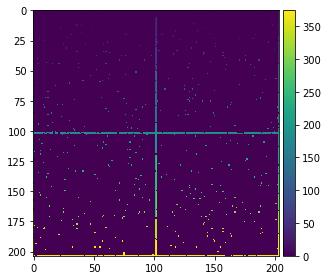

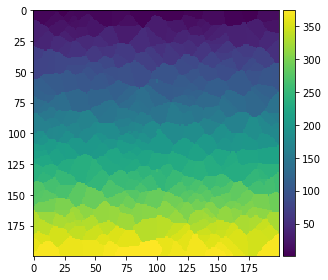

In [14]:
ws_neighbors = da.overlap.trim_overlap(ws_fp, depth=depth)
ws_neighbors = da.overlap.overlap(ws_neighbors, depth=depth, boundary='nearest')

full_labels_op = ws_markers_op.map_blocks(lambda x, y: build_full_markers(x, y, depth), ws_neighbors, dtype=ws_markers_op.dtype)
display(full_labels_op)

# sp = second pass
ws_sp_op = hmax_op.map_blocks(lambda x, y: watershed(x, markers=y, watershed_line=True), full_labels_op, dtype=hmax_op.dtype)
ws_final = da.overlap.trim_overlap(ws_sp_op, depth=depth)
ws_final = ws_final.map_blocks(lambda x: skimage.morphology.dilation(x, selem=np.ones((3,3))), dtype=ws_final.dtype)
display(ws_final)            

### Validation

Note there are some different basin assignments between the methods. Pay particular attention to the error-free strip along the bottom 1/4 of the image. That strip seems to stay through seed changes, and even flipping the salt image along the vertical axis.

C:\Users\wwarr\AppData\Local\Continuum\anaconda3\envs\dask_test\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:75: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "
Error count: 391
Error fraction: 0.978%


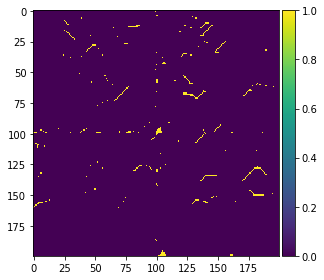

In [15]:
error = ~(ws == ws_final).compute()
display(error)

error_count = error.sum()
print("Error count: {:d}".format(error_count))
print("Error fraction: {:.3%}".format(error_count / error.size))